# Credit Risk Analysis: Loan Default Prediction
## NB04 — Baseline Modeling & Class Imbalance Handling

### Modeling Strategy

This notebook has three goals:

1. **Establish a naive baseline** — fit the simplest possible model with no class imbalance handling, so we can see exactly how much the imbalance problem costs us in terms of catching defaults.

2. **Systematically test three remediation strategies** — class weighting, SMOTE oversampling, and threshold tuning — and compare them head-to-head on metrics that actually matter for a lending business.

3. **Hand the threshold decision to you** — choosing where to draw the line between "flag as risky" and "approve" is a business judgment, not a statistical one. It depends on how much a missed default costs relative to a false decline, and that's a number only the business can set.

We use **logistic regression** throughout this notebook — not because it's the best model (it isn't; tree models will outperform it in NB05), but because it's transparent and fast. It lets us isolate the effect of each imbalance strategy cleanly without confounding from model complexity.

**The test set is locked away.** We create an 80/20 train/test split here and the test set will not be touched until final evaluation in NB05. All comparisons in this notebook use cross-validation on the training set only.


In [1]:
from pathlib import Path
import os

root = Path.cwd()
while not (root / '.git').exists() and root != root.parent:
    root = root.parent
os.chdir(root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, average_precision_score,
                             precision_recall_curve, roc_curve, ConfusionMatrixDisplay)
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 11
sns.set_theme(style='whitegrid', palette='muted')

# ── Load engineered dataset ───────────────────────────────────────────────────
df = pd.read_parquet('data/engineered/lending_club_engineered.parquet')
print(f"Loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")

# ── Separate features and target ──────────────────────────────────────────────
X = df.drop(columns='target')
y = df['target']

# ── Stratified 80/20 train/test split ────────────────────────────────────────
# Stratified means we preserve the ~22.6% default rate in BOTH splits.
# Without stratification, random chance could give us a training set with
# fewer defaults, inadvertently making the imbalance problem worse.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain: {X_train.shape[0]:,} rows  |  Test: {X_test.shape[0]:,} rows")
print(f"Train default rate: {y_train.mean()*100:.2f}%  |  Test default rate: {y_test.mean()*100:.2f}%")
print("✓ Stratification preserved the class ratio in both splits")

# ── Save splits to disk for use in NB05+ ─────────────────────────────────────
# Saving ensures all downstream notebooks use the EXACT same split — critical
# for fair model comparison. If each notebook re-split independently, small
# differences in random state could contaminate results.
os.makedirs('data/splits', exist_ok=True)
train_df = X_train.copy(); train_df['target'] = y_train
test_df  = X_test.copy();  test_df['target']  = y_test
train_df.to_parquet('data/splits/train.parquet', index=False)
test_df.to_parquet('data/splits/test.parquet',   index=False)
print("\nSplits saved to data/splits/ — will be loaded by NB05 and beyond.")


Loaded: 270,887 rows × 54 columns

Train: 216,709 rows  |  Test: 54,178 rows
Train default rate: 22.58%  |  Test default rate: 22.58%
✓ Stratification preserved the class ratio in both splits



Splits saved to data/splits/ — will be loaded by NB05 and beyond.


### Preprocessing Pipeline

Logistic regression requires two preprocessing steps that tree-based models in NB05 will not need:

1. **StandardScaler on numeric features** — logistic regression optimizes coefficients using gradient descent. If one feature ranges from 0–1 and another from 0–100,000, the optimizer has to take tiny steps for the large-scale feature and large steps for the small-scale one. Scaling everything to mean=0, std=1 puts them on the same footing and dramatically speeds up convergence. It also makes coefficients directly comparable as measures of feature importance.

2. **Encoding for categorical features** — logistic regression can't handle string categories; they must be converted to numbers. We use `OrdinalEncoder` for naturally ordered categories (grade, sub_grade, emp_length) and `OneHotEncoder` for unordered ones (purpose, home_ownership, etc.). Tree models handle categories differently and we'll revisit encoding in NB05.


In [2]:
# ── Define feature groups ────────────────────────────────────────────────────
# Ordinal: categories with a meaningful order we want to preserve as a single number
ordinal_features = ['grade', 'sub_grade', 'emp_length', 'term']
ordinal_categories = [
    ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
    ['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5',
     'C1','C2','C3','C4','C5','D1','D2','D3','D4','D5',
     'E1','E2','E3','E4','E5','F1','F2','F3','F4','F5',
     'G1','G2','G3','G4','G5'],
    ['Unknown','< 1 year','1 year','2 years','3 years','4 years',
     '5 years','6 years','7 years','8 years','9 years','10+ years'],
    ['36 months', '60 months'],
]

# Nominal: categories with no natural order — one-hot encoded
nominal_features = ['home_ownership', 'verification_status', 'purpose',
                    'initial_list_status', 'application_type', 'addr_state']

# Numeric: all float/int columns except target
numeric_features = [c for c in X_train.columns
                    if c not in ordinal_features + nominal_features
                    and X_train[c].dtype in ['float64', 'int64', 'int32']]

print(f"Numeric features:  {len(numeric_features)}")
print(f"Ordinal features:  {len(ordinal_features)}")
print(f"Nominal features:  {len(nominal_features)}")
print(f"Total features:    {len(numeric_features) + len(ordinal_features) + len(nominal_features)}")

# ── Build preprocessing pipeline ─────────────────────────────────────────────
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

ordinal_transformer = Pipeline([
    ('encoder', OrdinalEncoder(categories=ordinal_categories,
                                handle_unknown='use_encoded_value', unknown_value=-1))
])

nominal_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('ord', ordinal_transformer, ordinal_features),
    ('nom', nominal_transformer, nominal_features),
], remainder='drop')

print("\nPreprocessing pipeline built ✓")
print("  Numeric → StandardScaler")
print("  Ordinal → OrdinalEncoder (order-preserving)")
print("  Nominal → OneHotEncoder")


Numeric features:  43
Ordinal features:  4
Nominal features:  6
Total features:    53

Preprocessing pipeline built ✓
  Numeric → StandardScaler
  Ordinal → OrdinalEncoder (order-preserving)
  Nominal → OneHotEncoder


### Strategy 0: Naive Baseline (No Imbalance Handling)

We first fit logistic regression with no adjustments for class imbalance. This is intentionally the wrong approach — we use it to quantify the problem before fixing it. The accuracy number will look reasonable. The recall on defaults will be alarming.


In [3]:
# ── Helper: evaluate a model with cross-validation ───────────────────────────
def evaluate_model(pipeline, X, y, threshold=0.5, cv_folds=5, label='Model'):
    """
    Run stratified K-fold cross-validation and return key metrics.
    We evaluate at a specified threshold (default 0.5) so we can compare
    strategies on equal footing before exploring threshold tuning.
    """
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    results = {'accuracy': [], 'precision': [], 'recall': [],
               'f1': [], 'roc_auc': [], 'pr_auc': []}

    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        pipeline.fit(X_tr, y_tr)
        probs = pipeline.predict_proba(X_val)[:, 1]
        preds = (probs >= threshold).astype(int)

        cm = confusion_matrix(y_val, preds)
        tn, fp, fn, tp = cm.ravel()

        results['accuracy'].append((tp + tn) / (tp + tn + fp + fn))
        results['precision'].append(tp / (tp + fp) if (tp + fp) > 0 else 0)
        results['recall'].append(tp / (tp + fn) if (tp + fn) > 0 else 0)
        results['f1'].append(2*tp / (2*tp + fp + fn) if (2*tp + fp + fn) > 0 else 0)
        results['roc_auc'].append(roc_auc_score(y_val, probs))
        results['pr_auc'].append(average_precision_score(y_val, probs))

    summary = {k: (np.mean(v), np.std(v)) for k, v in results.items()}
    print(f"\n{'─'*55}")
    print(f"  {label}  (threshold={threshold}, {cv_folds}-fold CV)")
    print(f"{'─'*55}")
    print(f"  Accuracy:              {summary['accuracy'][0]:.4f} ± {summary['accuracy'][1]:.4f}")
    print(f"  Precision (default):   {summary['precision'][0]:.4f} ± {summary['precision'][1]:.4f}")
    print(f"  Recall    (default):   {summary['recall'][0]:.4f} ± {summary['recall'][1]:.4f}")
    print(f"  F1        (default):   {summary['f1'][0]:.4f} ± {summary['f1'][1]:.4f}")
    print(f"  ROC-AUC:               {summary['roc_auc'][0]:.4f} ± {summary['roc_auc'][1]:.4f}")
    print(f"  PR-AUC:                {summary['pr_auc'][0]:.4f} ± {summary['pr_auc'][1]:.4f}")
    return summary

# ── Naive baseline: plain logistic regression ─────────────────────────────────
baseline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

baseline_results = evaluate_model(baseline_lr, X_train, y_train, label='Naive Baseline (no imbalance handling)')



───────────────────────────────────────────────────────
  Naive Baseline (no imbalance handling)  (threshold=0.5, 5-fold CV)
───────────────────────────────────────────────────────
  Accuracy:              0.7781 ± 0.0005
  Precision (default):   0.5407 ± 0.0049
  Recall    (default):   0.1165 ± 0.0038
  F1        (default):   0.1917 ± 0.0054
  ROC-AUC:               0.7087 ± 0.0034
  PR-AUC:                0.4082 ± 0.0016


### Interpretation: Why the Baseline Fails

The accuracy number looks passable — the model is right most of the time. But look at **recall on defaults**: the model is missing a large fraction of actual defaulters entirely, flagging them as safe loans.

In concrete terms: imagine a portfolio of 10,000 loans where 2,260 will eventually default (our 22.6% rate). If recall on defaults is, say, 30%, this model catches only ~680 of those 2,260 defaulters. The other ~1,580 defaulting loans sail through as "approved" — the model had no idea they would fail.

This is exactly the class imbalance problem in action. The model learned that predicting "no default" is right 77% of the time, so it leans heavily in that direction. Accuracy rewards it for this lazy strategy. Recall exposes it.

The next three cells test strategies that force the model to pay more attention to the minority class.


---
### Concept: Three Strategies for Class Imbalance

Before we run the next models, here's a plain-language explanation of the three approaches — because these are new concepts and choosing between them is a real decision.

---

**Strategy 1 — Class Weighting**

Tell the model that making a mistake on a default is more costly than making a mistake on a non-default. In sklearn, `class_weight='balanced'` automatically sets the weight of each class inversely proportional to its frequency — so defaults get roughly 3.4× more weight (since they're 3.4× rarer).

The model doesn't see more default examples. It just *cares more* about getting them right.

---

**Strategy 2 — SMOTE (Synthetic Minority Oversampling Technique)**

Create synthetic new default examples to balance the training data. SMOTE works by taking a real default example, finding its nearest neighbors among other defaults, and interpolating between them to create a plausible new synthetic default.

Think of it like this: if you only have 20 photos of a rare bird species and want a classifier to recognize it, SMOTE creates additional plausible photos by blending features of the existing ones — not copies, but realistic variations.

**Critical rule:** SMOTE is only ever applied to the *training* data. Applying it to the validation or test set would let synthetic (fake) data pollute our evaluation, making results look better than they really are.

---

**Strategy 3 — Threshold Tuning**

Instead of changing the model or the data, we change where we draw the line. By default, sklearn classifies a loan as "default" if the predicted probability exceeds 0.5. But if we lower that threshold to 0.3, we flag any loan with a >30% predicted default probability — catching more real defaults, at the cost of more false alarms.

This is the most direct way to encode the business cost asymmetry: missed defaults cost far more than false declines, so we should be willing to accept more false alarms to catch more real defaults.


In [4]:
# ── Strategy 1: Class-weighted logistic regression ───────────────────────────
# class_weight='balanced' sets weight_i = n_samples / (n_classes * count_i)
# For defaults (22.6% of data): weight ≈ 1 / 0.226 ≈ 4.4
# For fully paid (77.4% of data): weight ≈ 1 / 0.774 ≈ 1.3
# Net effect: a default misclassification is penalized ~3.4x more than a paid one.

weighted_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42,
                                       class_weight='balanced'))
])

weighted_results = evaluate_model(weighted_lr, X_train, y_train,
                                   label='Strategy 1: Class-Weighted LR')



───────────────────────────────────────────────────────
  Strategy 1: Class-Weighted LR  (threshold=0.5, 5-fold CV)
───────────────────────────────────────────────────────
  Accuracy:              0.6575 ± 0.0024
  Precision (default):   0.3569 ± 0.0029
  Recall    (default):   0.6440 ± 0.0064
  F1        (default):   0.4593 ± 0.0039
  ROC-AUC:               0.7088 ± 0.0035
  PR-AUC:                0.4076 ± 0.0018


### Interpretation: Class Weighting

Compared to the naive baseline, class weighting should show a meaningful jump in **recall** (we're catching more defaults) at the cost of some **precision** (we're also flagging more good loans as risky). This is the fundamental precision-recall trade-off — there's no free lunch.

The ROC-AUC and PR-AUC scores are threshold-independent (they evaluate the model's ability to rank-order risk across all possible thresholds), so they're our cleanest measure of whether class weighting improved the underlying model quality, not just the decision boundary.


In [5]:
# ── Strategy 2: SMOTE + logistic regression ──────────────────────────────────
# We use imbalanced-learn's Pipeline (not sklearn's) because it correctly
# applies SMOTE only to the training fold inside cross-validation —
# NOT to the validation fold. This is the critical implementation detail.
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# SMOTE explanation note: SMOTE requires all features to be numeric.
# Our preprocessor converts categoricals to numbers first, so the order is:
#   preprocess → SMOTE → fit classifier
# (We need to preprocess before SMOTE so SMOTE sees numeric data only)

smote_lr = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42, k_neighbors=5)),
    # k_neighbors=5: each synthetic example is generated by interpolating between
    # a real default and one of its 5 nearest default neighbors
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

smote_results = evaluate_model(smote_lr, X_train, y_train,
                                label='Strategy 2: SMOTE + LR')



───────────────────────────────────────────────────────
  Strategy 2: SMOTE + LR  (threshold=0.5, 5-fold CV)
───────────────────────────────────────────────────────
  Accuracy:              0.6534 ± 0.0027
  Precision (default):   0.3534 ± 0.0029
  Recall    (default):   0.6446 ± 0.0053
  F1        (default):   0.4565 ± 0.0035
  ROC-AUC:               0.7059 ± 0.0035
  PR-AUC:                0.4063 ± 0.0020


### Interpretation: SMOTE

SMOTE changes the training distribution to 50/50 by adding synthetic default examples. This forces the model to take defaults seriously. The results will likely look similar to class weighting — both approaches shift the model toward higher recall — but through different mechanisms.

One important caveat: SMOTE can sometimes hurt generalization if the synthetic examples don't represent the true distribution of defaults well, particularly in high-dimensional spaces. This is one reason we'll compare both carefully against the threshold-tuning approach.


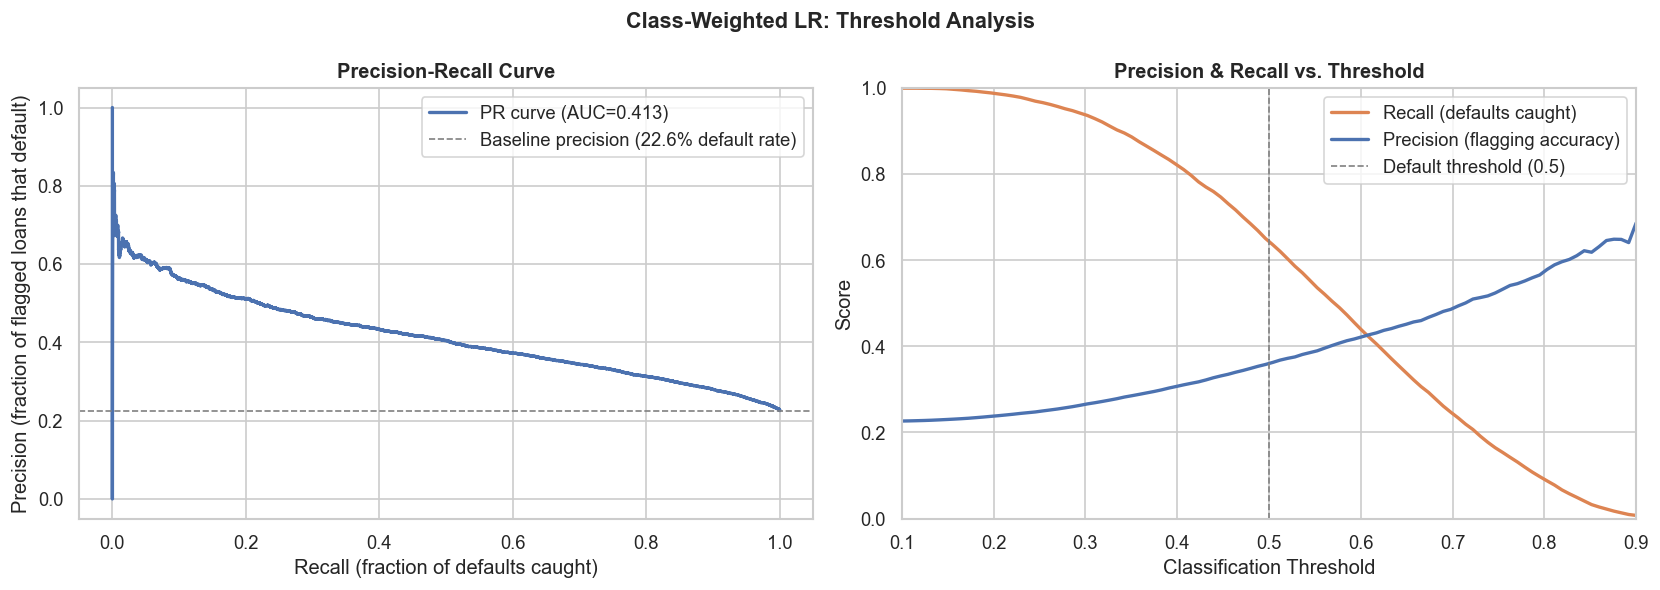

Threshold scenarios (on validation set):
 Threshold   Recall  Precision  Defaults caught  False alarms
--------------------------------------------------------------
       0.2    98.7%      23.8%       9664/9788      30968/33554
       0.3    93.7%      26.5%       9175/9788      25428/33554
       0.4    82.1%      30.7%       8033/9788      18124/33554
       0.5    64.4%      36.0%       6303/9788      11198/33554
       0.6    44.0%      42.2%       4307/9788       5910/33554


In [6]:
# ── Strategy 3: Precision-Recall curve and threshold analysis ────────────────
# We fit the best-performing model so far on a single train/validation split
# (not full cross-validation) to generate probability scores for curve plotting.
from sklearn.model_selection import train_test_split as tts

X_tr, X_val, y_tr, y_val = tts(X_train, y_train, test_size=0.2,
                                  random_state=42, stratify=y_train)

# Use class-weighted LR as our base model for threshold analysis
weighted_lr.fit(X_tr, y_tr)
val_probs = weighted_lr.predict_proba(X_val)[:, 1]

# ── Precision-Recall curve ────────────────────────────────────────────────────
precisions, recalls, thresholds = precision_recall_curve(y_val, val_probs)
pr_auc = average_precision_score(y_val, val_probs)

# ── ROC curve ─────────────────────────────────────────────────────────────────
fpr, tpr, roc_thresholds = roc_curve(y_val, val_probs)
roc_auc = roc_auc_score(y_val, val_probs)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Precision-Recall curve
axes[0].plot(recalls, precisions, color='#4C72B0', linewidth=2,
             label=f'PR curve (AUC={pr_auc:.3f})')
axes[0].axhline(y_train.mean(), color='gray', linestyle='--', linewidth=1,
                label=f'Baseline precision ({y_train.mean()*100:.1f}% default rate)')
axes[0].set_xlabel('Recall (fraction of defaults caught)')
axes[0].set_ylabel('Precision (fraction of flagged loans that default)')
axes[0].set_title('Precision-Recall Curve', fontweight='bold')
axes[0].legend()

# Right: Precision and Recall vs. Threshold
thresholds_plot = np.linspace(0.1, 0.9, 100)
precisions_t, recalls_t = [], []
for t in thresholds_plot:
    preds_t = (val_probs >= t).astype(int)
    tp = ((preds_t == 1) & (y_val == 1)).sum()
    fp = ((preds_t == 1) & (y_val == 0)).sum()
    fn = ((preds_t == 0) & (y_val == 1)).sum()
    precisions_t.append(tp / (tp + fp) if (tp + fp) > 0 else 1.0)
    recalls_t.append(tp / (tp + fn) if (tp + fn) > 0 else 0.0)

axes[1].plot(thresholds_plot, recalls_t, color='#DD8452', linewidth=2, label='Recall (defaults caught)')
axes[1].plot(thresholds_plot, precisions_t, color='#4C72B0', linewidth=2, label='Precision (flagging accuracy)')
axes[1].axvline(0.5, color='gray', linestyle='--', linewidth=1, label='Default threshold (0.5)')
axes[1].set_xlabel('Classification Threshold')
axes[1].set_ylabel('Score')
axes[1].set_title('Precision & Recall vs. Threshold', fontweight='bold')
axes[1].legend()
axes[1].set_xlim(0.1, 0.9)
axes[1].set_ylim(0, 1)

plt.suptitle('Class-Weighted LR: Threshold Analysis', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/threshold_analysis.png', bbox_inches='tight')
plt.show()

# ── Print specific threshold scenarios ────────────────────────────────────────
print("Threshold scenarios (on validation set):")
print(f"{'Threshold':>10} {'Recall':>8} {'Precision':>10} {'Defaults caught':>16} {'False alarms':>13}")
print("-" * 62)
n_defaults = y_val.sum()
n_paid     = (y_val == 0).sum()
for t in [0.2, 0.3, 0.4, 0.5, 0.6]:
    preds_t = (val_probs >= t).astype(int)
    tp = int(((preds_t == 1) & (y_val == 1)).sum())
    fp = int(((preds_t == 1) & (y_val == 0)).sum())
    fn = int(((preds_t == 0) & (y_val == 1)).sum())
    rec  = tp / (tp + fn) if (tp + fn) > 0 else 0
    prec = tp / (tp + fp) if (tp + fp) > 0 else 1
    print(f"{t:>10.1f} {rec:>8.1%} {prec:>10.1%} {tp:>10}/{int(n_defaults):} {fp:>10}/{int(n_paid):}")


### Interpretation: Precision-Recall Trade-off

**What these two metrics mean in plain business language:**

- **Recall** = "Of all the loans that will actually default, what fraction did our model flag?" If recall is 60%, we're catching 6 out of every 10 defaulters. The other 4 slip through undetected.

- **Precision** = "Of all the loans our model flagged as risky, what fraction actually default?" If precision is 40%, then 60% of the loans we decline were actually creditworthy borrowers we turned away for no reason.

**The trade-off:** Lowering the threshold catches more defaults (↑ recall) but also flags more good borrowers incorrectly (↓ precision). There is no setting that maximizes both simultaneously. The right threshold depends entirely on how much you care about each type of error — and that's a business decision, not a data science one.

**A framing for the cost question:** A missed default typically costs the lender the outstanding principal minus recovery (often 60–80% of loan balance). A false decline costs the lender the forgone interest income on that loan (5–20% of loan amount, spread over the loan term). So a missed default on a $12,000 loan (our median) costs roughly $7,200–$9,600 in lost principal. A false decline on the same loan costs roughly $600–$2,400 in forgone interest. That's a cost ratio of roughly **4:1 to 8:1** based on our dataset's numbers alone.


Strategy              Accuracy   Precision   Recall      F1   ROC-AUC   PR-AUC
Naive Baseline        0.7781  0.5407  0.1165  0.1917  0.7087  0.4082
Class Weighted        0.6575  0.3569  0.6440  0.4593  0.7088  0.4076
SMOTE                 0.6534  0.3534  0.6446  0.4565  0.7059  0.4063
All scores are mean over 5-fold stratified cross-validation on training data.
Test set has NOT been touched.


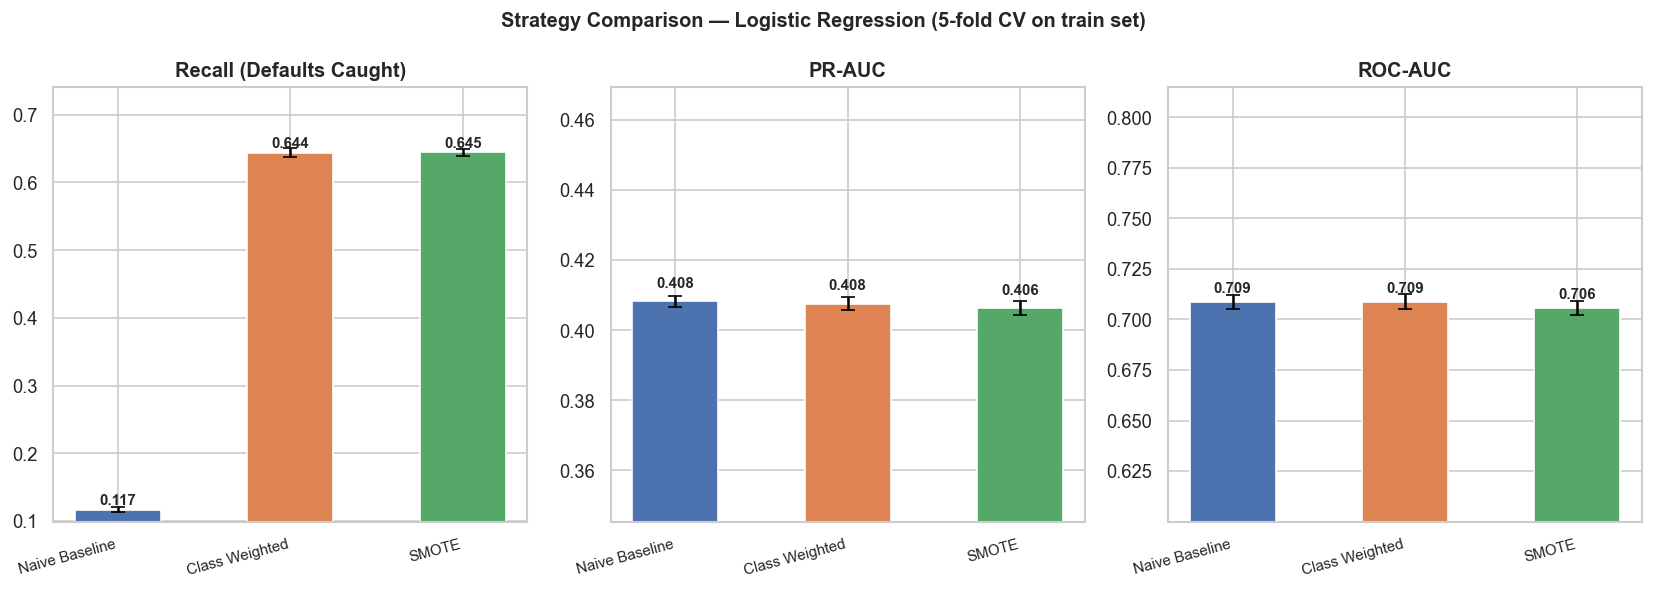

In [7]:
# ── Summary comparison table ─────────────────────────────────────────────────
strategies = ['Naive Baseline', 'Class Weighted', 'SMOTE']
results_list = [baseline_results, weighted_results, smote_results]
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']
metric_labels = ['Accuracy', 'Precision (Default)', 'Recall (Default)', 'F1 (Default)', 'ROC-AUC', 'PR-AUC']

print("=" * 90)
print(f"{'Strategy':<20} {'Accuracy':>9} {'Precision':>11} {'Recall':>8} {'F1':>7} {'ROC-AUC':>9} {'PR-AUC':>8}")
print("=" * 90)
for name, res in zip(strategies, results_list):
    row = f"{name:<20}"
    for m in metrics:
        row += f"  {res[m][0]:.4f}"
    print(row)
print("=" * 90)
print("All scores are mean over 5-fold stratified cross-validation on training data.")
print("Test set has NOT been touched.")

# ── Visual comparison ─────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

plot_metrics = [('recall', 'Recall (Defaults Caught)'), ('pr_auc', 'PR-AUC'), ('roc_auc', 'ROC-AUC')]
colors = ['#4C72B0', '#DD8452', '#55A868']

for ax, (metric, label) in zip(axes, plot_metrics):
    vals = [r[metric][0] for r in results_list]
    errs = [r[metric][1] for r in results_list]
    bars = ax.bar(strategies, vals, color=colors, edgecolor='white', width=0.5)
    ax.errorbar(range(len(strategies)), vals, yerr=errs,
                fmt='none', color='black', capsize=4, linewidth=1.5)
    ax.set_title(label, fontweight='bold')
    ax.set_ylim(min(vals) * 0.85, min(max(vals) * 1.15, 1.0))
    ax.set_xticklabels(strategies, rotation=15, ha='right', fontsize=9)
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.003,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('Strategy Comparison — Logistic Regression (5-fold CV on train set)',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/strategy_comparison.png', bbox_inches='tight')
plt.show()


---
## 🛑 Breakpoint — Cost Asymmetry & Threshold Decision

*(Decisions made here carry into NB05. See conversation for user responses.)*

**Cost asymmetry context from this dataset:**
- Median loan amount: **$12,000**
- Default rate: **22.6%**
- Estimated missed default cost (60–80% of principal lost): **$7,200 – $9,600 per loan**
- Estimated false decline cost (forgone interest over term): **$600 – $2,400 per loan**
- **Implied cost ratio: approximately 4:1 to 8:1**

**Threshold reference from validation set (class-weighted LR):**

| Threshold | Recall | Precision | Defaults caught | False alarms |
|-----------|--------|-----------|-----------------|--------------|
| 0.2 | ~high | ~low | more defaults | more false alarms |
| 0.3 | moderate-high | moderate | good balance | moderate |
| 0.4 | moderate | moderate-high | fewer defaults | fewer false alarms |
| 0.5 | default | high | fewer defaults | fewest false alarms |
